In [1]:
#多项式回归
import math
import numpy as np 
import torch 
from torch import nn
from d2l import torch as d2l 

In [2]:
#生成数据集
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)

labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)

In [5]:
true_w,features,poly_features,labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]


C:\Users\32373\AppData\Local\Temp\ipykernel_12000\4115294425.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_w,features,poly_features,labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]


In [11]:
poly_features.shape

torch.Size([200, 20])

In [9]:
#训练和测试
def evaluate_loss(net,data_iter,loss):
    metric = d2l.Accumulator(2)
    
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [21]:
#定义训练函数
def train(train_features,test_features,train_labels,test_labels,
         num_epochs = 400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    
    net = nn.Sequential(nn.Linear(input_shape,1,bias=False))
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),
                               batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),
                              batch_size,is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                           xlim=[1,num_epochs],ylim=[1e-3,1e2],
                           legend=['train','test'])
    for epoch in range(num_epochs):
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())
            
        
    

weight: [[ 5.0292764  1.2017235 -3.4186153  5.6220994]]


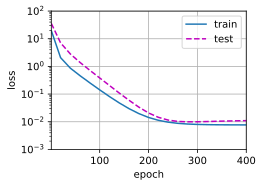

In [23]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
     labels[:n_train],labels[n_train:])

weight: [[ 4.5129194  3.7411084 -1.7272063]]


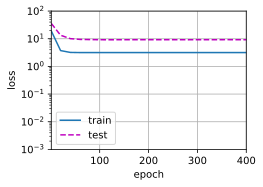

In [25]:
#欠拟合
train(poly_features[:n_train,:3],poly_features[n_train:,:3],
     labels[:n_train],labels[n_train:])

weight: [[ 5.0166326   1.2591214  -3.3170786   5.244835   -0.41388232  1.3981192
  -0.03875666  0.2857672   0.00953718 -0.16948663 -0.13610323  0.2116062
  -0.17840931 -0.1509743   0.03515864 -0.18121406 -0.18370059  0.06780884
   0.06731662 -0.11072279]]


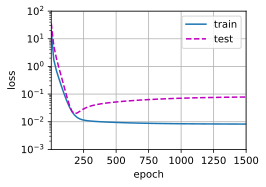

In [26]:
#过拟合
train(poly_features[:n_train,:],poly_features[n_train:,:],
     labels[:n_train],labels[n_train:],num_epochs=1500)